In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
from collections import defaultdict, Counter
import _pickle as pickle
import random
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
training_auroc_trees = pickle.load(open('../data/training_auroc_tree.p','rb'))
training_oob_auroc_trees = pickle.load(open('../data/training_oob_auroc_tree.p','rb'))
testing_auroc_trees = pickle.load(open('../data/testing_auroc_tree.p', 'rb'))

In [4]:
colors = sns.color_palette("colorblind", 3).as_hex()

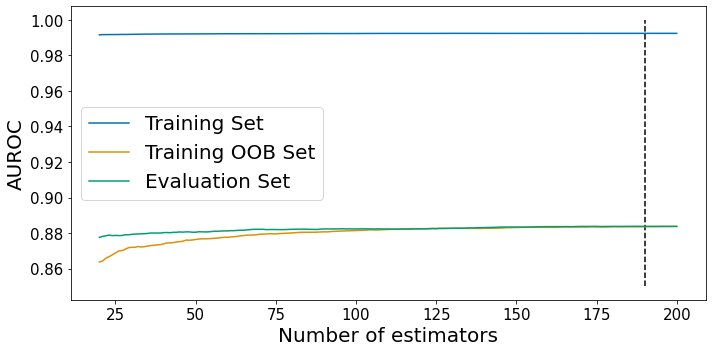

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(training_auroc_trees.keys(), training_auroc_trees.values(), label = 'Training Set', color=colors[0])
plt.plot(training_oob_auroc_trees.keys(), training_oob_auroc_trees.values(), label = 'Training OOB Set', color=colors[1])
plt.plot(testing_auroc_trees.keys(), testing_auroc_trees.values(), label = 'Evaluation Set', color=colors[2])
plt.vlines(x=190, linestyles='dashed', ymin=0.85, ymax=1, color='black')
plt.ylabel('AUROC', size=20)
plt.xlabel('Number of estimators', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(prop={'size': 20}, loc=6)
plt.tight_layout()
plt.savefig('figure_2_a_auroc_trees.pdf')
plt.show()

In [9]:
training_auroc_depth = pickle.load(open('../data/training_auroc_depth.p','rb'))
training_oob_auroc_depth = pickle.load(open('../data/training_oob_auroc_depth.p','rb'))
testing_auroc_depth = pickle.load(open('../data/testing_auroc_depth.p', 'rb'))

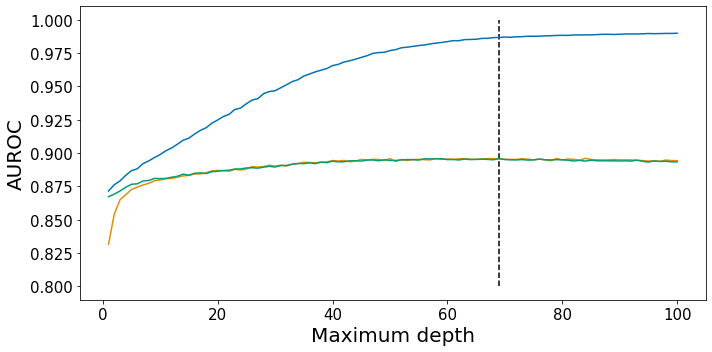

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(training_auroc_depth.keys(), training_auroc_depth.values(), label = 'Training Set', color=colors[0])
plt.plot(training_oob_auroc_depth.keys(), training_oob_auroc_depth.values(), label = 'Training OOB Set', color=colors[1])
plt.plot(testing_auroc_depth.keys(), testing_auroc_depth.values(), label = 'Evaluation Set', color=colors[2])
plt.vlines(x=69, linestyles='dashed', ymin=0.80, ymax=1, color='black')
plt.xlabel('Maximum depth', size=20)
plt.ylabel('AUROC', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('figure_2_b_auroc_depth.pdf')
plt.show()

In [17]:
demographic_matrix = pickle.load(open('../data/demographic_matrix.p', 'rb'))
demographic_variables = pickle.load(open('../data/demographic_variables.p', 'rb'))
datetime_matrix = pickle.load(open('../data/datetime_matrix.p', 'rb'))
datetime_variables = pickle.load(open('../data/datetime_variables.p', 'rb'))
diag_matrix = pickle.load(open('../data/diag_matrix.p', 'rb'))
diag_variables = pickle.load(open('../data/diag_variables.p', 'rb'))
negative_training_set = pickle.load(open('../data/negative_training_set.p', 'rb'))
positive_training_set = pickle.load(open('../data/positive_training_set.p', 'rb'))

In [18]:
full_matrix = []

for pat_enc_csn_id in positive_training_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix.append(to_add)
    
for pat_enc_csn_id in negative_training_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix.append(to_add)

In [19]:
Counter([len(i) for i in full_matrix])

Counter({1637: 9340})

In [20]:
full_variable_list = demographic_variables + datetime_variables[:-1] + diag_variables
len(full_variable_list)

1637

In [21]:
len(positive_training_set), len(negative_training_set)

(4670, 4670)

In [22]:
covid_non_covid_visits = [1 for i in range(4670)] + [0 for i in range(4670)]
len(covid_non_covid_visits), Counter(covid_non_covid_visits)

(9340, Counter({1: 4670, 0: 4670}))

In [23]:
full_matrix = np.array(full_matrix)

In [24]:
negative_testing_set = pickle.load(open('../data/negative_eval_set.p', 'rb'))
positive_testing_set = pickle.load(open('../data/positive_eval_set.p', 'rb'))

In [25]:
full_matrix_testing = []

for pat_enc_csn_id in positive_testing_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix_testing.append(to_add)
    
for pat_enc_csn_id in negative_testing_set:
    to_add = demographic_matrix[pat_enc_csn_id]
    to_add += datetime_matrix[pat_enc_csn_id]
    to_add += diag_matrix[pat_enc_csn_id]
    full_matrix_testing.append(to_add)

In [26]:
covid_non_covid_visits_testing = [1 for i in range(4670)] + [0 for i in range(4670)]
len(covid_non_covid_visits_testing), Counter(covid_non_covid_visits_testing)

(9340, Counter({1: 4670, 0: 4670}))

In [27]:
full_matrix_testing = np.array(full_matrix_testing)

In [28]:
rf = RandomForestClassifier(n_estimators=190, max_depth=69,random_state=1, oob_score=True)
rf.fit(full_matrix, covid_non_covid_visits)
estimate_covid_oob = rf.oob_decision_function_[:,1]
estimate_covid = rf.predict_proba(full_matrix)[:,1]
testing_covid = rf.predict_proba(full_matrix_testing)[:,1]

In [29]:
false_positive_rate_oob, true_positive_rate_oob, thresholds_oob = roc_curve(covid_non_covid_visits, estimate_covid_oob)
roc_auc_oob = auc(false_positive_rate_oob, true_positive_rate_oob)

false_positive_rate_training, true_positive_rate_training, thresholds_training = roc_curve(covid_non_covid_visits, estimate_covid)
roc_auc_training = auc(false_positive_rate_training, true_positive_rate_training)

false_positive_rate_testing, true_positive_rate_testing, thresholds_Tsting = roc_curve(covid_non_covid_visits_testing, testing_covid)
roc_auc = auc(false_positive_rate_testing, true_positive_rate_testing)

In [30]:
roc_auc_oob, roc_auc_training, roc_auc

(0.8957386892507186, 0.9866616381385582, 0.8958289276396334)

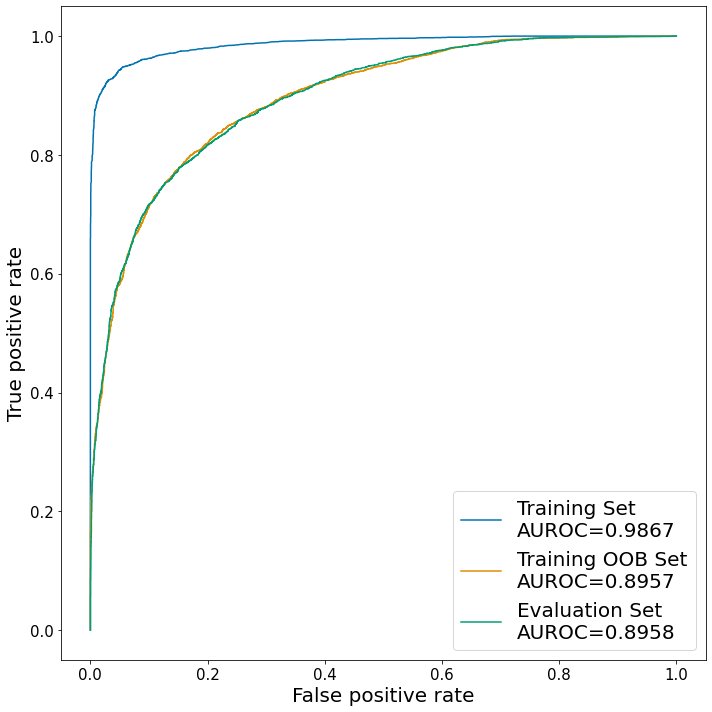

In [31]:
plt.figure(figsize=(10, 10))
plt.plot(false_positive_rate_training, true_positive_rate_training, label = 'Training Set\nAUROC=0.9867', color=colors[0])
plt.plot(false_positive_rate_oob, true_positive_rate_oob, label = 'Training OOB Set\nAUROC=0.8957', color=colors[1])
plt.plot(false_positive_rate_testing, true_positive_rate_testing, label = 'Evaluation Set\nAUROC=0.8958', color=colors[2])
plt.xlabel('False positive rate', size=20)
plt.ylabel('True positive rate', size=20)
plt.legend(prop={'size': 20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('figure_2_c_roc_final.pdf')
plt.show()